In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('/content/course_lead_scoring.csv')

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Preparation
- Check if the missing values are presented in the features.
- If there are missing values:
  - For caterogiral features, replace them with 'NA'
  - For numerical features, replace with with 0.0

In [4]:
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
# Identify categorical and numerical columns with missing values
categorical_cols_with_na = df.select_dtypes(include='object').columns[df.select_dtypes(include='object').isnull().any()]
numerical_cols_with_na = df.select_dtypes(include=np.number).columns[df.select_dtypes(include=np.number).isnull().any()]

# Fill missing values
df[categorical_cols_with_na] = df[categorical_cols_with_na].fillna('NA')
df[numerical_cols_with_na] = df[numerical_cols_with_na].fillna(0.0)

# Verify that missing values have been filled
print("Missing values after imputation:")
display(df.isnull().sum())

Missing values after imputation:


,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


### Question 1

What is the most frequent observation (mode) for the column industry?

In [7]:
df['industry'].mode()

,industry
0,retail


### Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

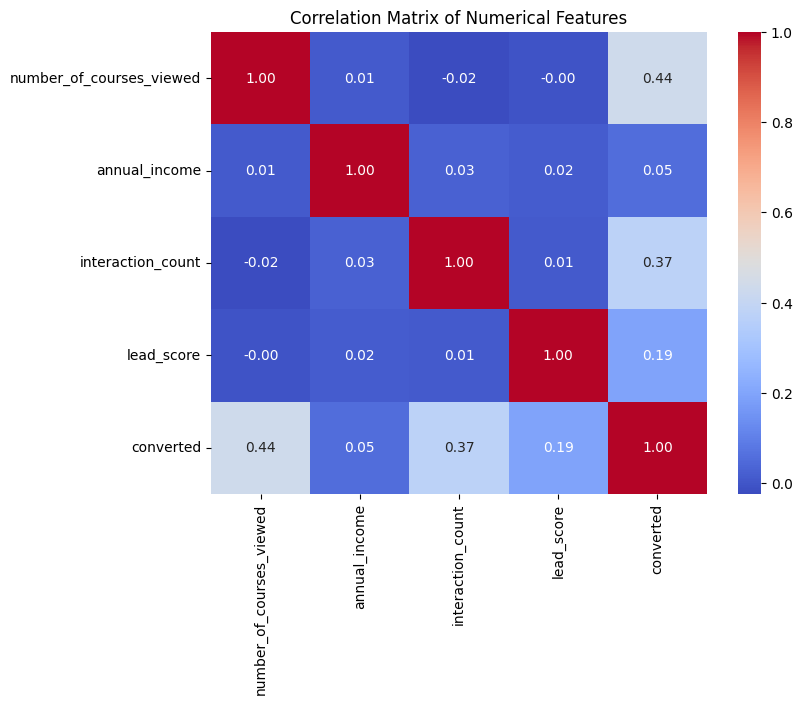

In [11]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()


# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('converted', axis=1)
y = df['converted']

# Split data into training (60%) and temporary (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temporary data into validation (20%) and test (20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (877, 8)
Shape of X_val: (292, 8)
Shape of X_test: (293, 8)
Shape of y_train: (877,)
Shape of y_val: (292,)
Shape of y_test: (293,)


### Question 3
- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

In [13]:
from sklearn.feature_selection import mutual_info_classif

# Select categorical columns from the training features
categorical_cols_train = X_train.select_dtypes(include='object')

# Calculate mutual information scores
# We need to handle potential issues with categorical data types,
# as mutual_info_classif expects discrete features.
# For simplicity and to proceed, we'll convert to category codes.
# A more robust approach might involve one-hot encoding or similar.
for col in categorical_cols_train.columns:
    categorical_cols_train[col] = categorical_cols_train[col].astype('category').cat.codes

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(categorical_cols_train, y_train, random_state=42)

# Create a pandas Series for better visualization of scores
mutual_info_series = pd.Series(mutual_info_scores, index=categorical_cols_train.columns)

# Round the scores to 2 decimal places
mutual_info_series_rounded = mutual_info_series.apply(lambda x: round(x, 2))

# Display the results
print("Mutual Information Scores (rounded to 2 decimals):")
display(mutual_info_series_rounded)

Mutual Information Scores (rounded to 2 decimals):


,0
lead_source,0.04
industry,0.03
employment_status,0.02
location,0.02


### Question 4
- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
  - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
  - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

# Identify categorical columns (excluding the target)
categorical_features = X_train.select_dtypes(include='object').columns

# Create a ColumnTransformer for one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)

# Apply one-hot encoding to the training and validation data
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)

# Initialize the Logistic Regression model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

# Fit the model on the encoded training data
model.fit(X_train_encoded, y_train)

# Make predictions on the encoded validation data
y_pred_val = model.predict(X_val_encoded)

# Calculate accuracy on the validation dataset
accuracy_val = accuracy_score(y_val, y_pred_val)

# Round the accuracy to 2 decimal places
accuracy_val_rounded = round(accuracy_val, 2)

# Display the rounded accuracy
print(f"Accuracy on the validation dataset (rounded to 2 decimals): {accuracy_val_rounded}")

Accuracy on the validation dataset (rounded to 2 decimals): 0.74


### Question 5
- Let's find the least useful feature using the feature elimination technique.
- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

In [15]:
# Initialize the Logistic Regression model with specified parameters
model_all_features = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

# Fit the model on the encoded training data
model_all_features.fit(X_train_encoded, y_train)

# Make predictions on the encoded validation data
y_pred_val_all_features = model_all_features.predict(X_val_encoded)

# Calculate accuracy on the validation dataset
accuracy_val_all_features = accuracy_score(y_val, y_pred_val_all_features)

# Display the accuracy
print(f"Accuracy on the validation dataset with all features: {accuracy_val_all_features}")

Accuracy on the validation dataset with all features: 0.7431506849315068


In [16]:
# Get the list of all feature columns
all_features = X_train.columns

# Initialize a dictionary to store accuracy differences
accuracy_differences = {}

# Iterate through each feature
for feature_to_drop in all_features:
    print(f"Dropping feature: {feature_to_drop}")

    # Create new training and validation DataFrames by dropping the current feature
    X_train_reduced = X_train.drop(columns=[feature_to_drop])
    X_val_reduced = X_val.drop(columns=[feature_to_drop])

    # Identify categorical columns in the reduced dataset
    categorical_features_reduced = X_train_reduced.select_dtypes(include='object').columns

    # Create a new ColumnTransformer for the reduced dataset
    preprocessor_reduced = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_reduced)
        ],
        remainder='passthrough' # Keep numerical columns as they are
    )

    # Apply one-hot encoding to the reduced training and validation data
    X_train_reduced_encoded = preprocessor_reduced.fit_transform(X_train_reduced)
    X_val_reduced_encoded = preprocessor_reduced.transform(X_val_reduced)

    # Initialize a new Logistic Regression model with the same parameters
    model_reduced = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

    # Fit the new model on the encoded reduced training data
    model_reduced.fit(X_train_reduced_encoded, y_train)

    # Make predictions on the encoded reduced validation data
    y_pred_val_reduced = model_reduced.predict(X_val_reduced_encoded)

    # Calculate accuracy of the new model on the validation set
    accuracy_val_reduced = accuracy_score(y_val, y_pred_val_reduced)

    # Calculate the difference in accuracy
    accuracy_diff = accuracy_val_all_features - accuracy_val_reduced

    # Store the accuracy difference
    accuracy_differences[feature_to_drop] = accuracy_diff

# Display the accuracy differences
print("\nAccuracy differences after dropping each feature:")
display(accuracy_differences)

Dropping feature: lead_source
Dropping feature: industry
Dropping feature: number_of_courses_viewed
Dropping feature: annual_income
Dropping feature: employment_status
Dropping feature: location
Dropping feature: interaction_count
Dropping feature: lead_score

Accuracy differences after dropping each feature:


{'lead_source': 0.013698630136986245,
 'industry': 0.0,
 'number_of_courses_viewed': 0.06506849315068486,
 'annual_income': -0.113013698630137,
 'employment_status': -0.003424657534246589,
 'location': 0.0,
 'interaction_count': 0.06849315068493145,
 'lead_score': 0.0}

### Question 6
- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Define the values of C to try
C_values = [0.01, 0.1, 1, 10, 100]

# Dictionary to store accuracies for each C value
accuracies = {}

# Iterate through each C value
for c in C_values:
    print(f"Training model with C = {c}")

    # Initialize the Logistic Regression model with the current C value and specified parameters
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)

    # Fit the model on the encoded training data (using the preprocessor from Q4)
    # Assuming X_train_encoded and X_val_encoded from Q4 are available
    model.fit(X_train_encoded, y_train)

    # Make predictions on the encoded validation data
    y_pred_val = model.predict(X_val_encoded)

    # Calculate accuracy on the validation dataset
    accuracy_val = accuracy_score(y_val, y_pred_val)

    # Store the accuracy
    accuracies[c] = accuracy_val

# Display the accuracies for each C value, rounded to 3 decimal places
print("\nAccuracy on the validation dataset for different C values:")
for c, acc in accuracies.items():
    print(f"C = {c}: {round(acc, 3)}")

Training model with C = 0.01
Training model with C = 0.1
Training model with C = 1
Training model with C = 10
Training model with C = 100

Accuracy on the validation dataset for different C values:
C = 0.01: 0.743
C = 0.1: 0.743
C = 1: 0.743
C = 10: 0.743
C = 100: 0.743
